Working notebook for masther thesis

In [248]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.io import loadmat
from scipy import stats
import statsmodels.api as sm
plt.style.use("ggplot")  
%matplotlib inline

from scipy.optimize import least_squares

from scipy.special import erf

from concurrent.futures import ProcessPoolExecutor
from typing import Iterable, Tuple, Dict, Optional

from scipy.stats import linregress

from tqdm import tqdm 

import openpyxl

Dataset preparation

In [249]:
mat =loadmat("/Users/davidsandovalrodriguez/Projects/Fund-Kink-Smoothing/data/TFMdata/AllB_JF.mat")

In [250]:
Y     = np.asarray(mat["Y"])       # 540 x 2321
TNA   = np.asarray(mat["TNA"])     # same shape
F     = np.asarray(mat["F"])       # 540 x 5
rf    = np.asarray(mat["rf"]).flatten()  # 540 x 1 → flatten to 1D
style = np.asarray(mat["stylemat"])      # 2321 x 18
fundids = mat["fundids"].flatten()       # 2321 × 1 → fund ID for each column

T, N = Y.shape

# Time and Fund grids
time_idx = np.arange(T)
fund_idx = np.arange(N)

time_grid, fund_grid = np.meshgrid(time_idx, fund_idx, indexing='ij')
df = pd.DataFrame({
    "time": time_grid.ravel(),
    "fund_index": fund_grid.ravel(),
    "fund_id": fundids[fund_grid.ravel()],
    "Y": Y.ravel(),
    "TNA": TNA.ravel(),
    # add more fields if needed (e.g., TNA1, etc.)
})

style_df = pd.DataFrame(style, columns=[f"style_{i+1}" for i in range(style.shape[1])])
style_df["fund_id"] = fundids
df = df.merge(style_df, on="fund_id", how="left")
df.replace(-999, np.nan, inplace=True)
df.shape

F_df = pd.DataFrame(F, columns=[f"F{i+1}" for i in range(F.shape[1])])
F_df["time"] = np.arange(F.shape[0])

# Merge into df
df = df.merge(F_df, on="time", how="left")

df = df.dropna(subset=["Y", "TNA"])
df.shape
df.head()

,time,fund_index,fund_id,Y,TNA,style_1,style_2,style_3,style_4,style_5,...,style_14,style_15,style_16,style_17,style_18,F1,F2,F3,F4,F5
5,0,5,100010,0.005069,64.361911,0,0,0,0,0,...,0,0,0,0,0,1.0,0.11781,0.128,0.0822,-0.1386
9,0,9,100019,0.158994,35.243098,0,0,0,1,0,...,0,0,0,0,0,1.0,0.11781,0.128,0.0822,-0.1386
15,0,15,100046,0.091393,57.922143,0,0,0,0,0,...,0,0,0,0,0,1.0,0.11781,0.128,0.0822,-0.1386
16,0,16,100047,0.135792,58.868593,0,0,0,0,0,...,0,0,0,0,0,1.0,0.11781,0.128,0.0822,-0.1386
18,0,18,100055,0.141008,3610.879183,0,0,0,0,0,...,0,0,0,0,0,1.0,0.11781,0.128,0.0822,-0.1386


In [251]:
df = df.sort_values(["fund_id","time"])  

Linear model

In [252]:
def estimate_one_fund_lin(fund_df):
    """Returns dict with a, b, beta1...betak, R2, SSE, n_obs for a single fund"""

    y = fund_df["Y"].to_numpy(float)

    X = fund_df[["TNA", "F2", "F3", "F4", "F5"]].copy()
    X.insert(0, "const", 1.0)
    X["TNA"] = -X["TNA"]

    mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
    X, y = X[mask].to_numpy(), y[mask]

    res = sm.OLS(y, X).fit()

    a_hat = res.params[0]
    b_hat = res.params[1]
    betas = res.params[2:]

    K_theory = a_hat / (2 * b_hat)

    out = {
        "a_lin":a_hat,
        "b_lin":b_hat,
        **{f"beta{j+1}": betas[j] for j in range(len(betas))},
        "R2": res.rsquared,
        "SSE": res.ssr,
        "n_obs": len(y),
        "K_the_lin": K_theory
    }

    return out



def estimate_all_funds_linear(df):
    """
    OLS of every fund in the dataset df
    """

    results = []

    for fid, g in tqdm(df.groupby("fund_id")):
        est = estimate_one_fund_lin(g)
        if est is not None:
            est["fund_id"]=fid
            results.append(est)

    return pd.DataFrame(results)





In [253]:
estimates_lin = estimate_all_funds_linear(df)

  0%|          | 0/2321 [00:00<?, ?it/s]

100%|██████████| 2321/2321 [00:01<00:00, 2277.90it/s]


In [254]:
estimates_lin

,a_lin,b_lin,beta1,beta2,beta3,beta4,R2,SSE,n_obs,K_the_lin,fund_id
0,0.001492,-2.660309e-07,0.962015,-0.018759,0.051107,0.028328,0.944872,0.036179,386,-2804.264635,100001
1,0.004300,1.583310e-06,1.009327,0.619777,-0.017121,0.039970,0.866277,0.109129,316,1357.875384,100003
2,0.004346,1.460467e-06,1.009456,0.147759,-0.277096,0.028058,0.922869,0.074584,419,1487.950849,100004
3,0.006741,5.913177e-07,0.843809,0.142745,0.331572,0.036263,0.907920,0.022755,184,5700.289753,100006
4,0.007891,1.787235e-05,1.085414,0.732124,-0.504707,0.145129,0.820675,0.224937,277,220.759662,100009
...,...,...,...,...,...,...,...,...,...,...,...
2316,0.007462,8.449768e-05,0.810392,1.071016,-0.041594,0.017310,0.933816,0.007655,62,44.154539,603104
2317,0.002532,-8.807708e-07,0.899121,0.269719,0.204654,-0.030219,0.888521,0.008236,60,-1437.521256,603146
2318,-0.002967,-4.924477e-05,1.082990,0.159256,0.228119,-0.043161,0.931297,0.006549,60,30.123806,603166
2319,0.002993,1.561511e-05,0.782134,-0.087441,0.321272,0.082336,0.872283,0.005384,63,95.829927,604486


Smoothed model

In [255]:
def S_h_gauss(q, K, h):
    """
    Gaussian CDF smooth step  ≈ 1{q <= K}.
    Vectorised for NumPy arrays.
    """
    z = (K - q) / (np.sqrt(2.0) * h)
    return 0.5 * (1.0 + erf(z))

def alpha_smooth_gauss(a, b, K, q, h):
    S  = S_h_gauss(q, K, h)
    return (a - b*q) * S + (a*K - b*K**2) / q * (1.0 - S)

def residuals(theta, q, y, F, h):
    a, b, K   = theta[:3]
    betas     = theta[3:]
    alpha_hat = alpha_smooth_gauss(a, b, K, q, h)  
    y_hat     = alpha_hat + F.dot(betas)
    return y_hat - y


In [256]:
h_param = 0.001

estimating wrappers

In [257]:
def estimate_one_fund(fund_df, h=0.01):
    """Return dict with a,b,K,beta1..betaK,SSE,n_obs for a single fund."""
    fund_df = fund_df.sort_values("time")
    q = fund_df["TNA"].to_numpy(float)            #lagged size
    y = fund_df["Y"].to_numpy(float)
    F = fund_df[["F2","F3","F4","F5"]].to_numpy(float)

    mask = (~np.isnan(q)) & (~np.isnan(y)) & (~np.isnan(F).any(axis=1)) & (q > 0)
    q, y, F = q[mask], y[mask], F[mask]
    if len(q) < 24:  
        print(q)             # skip tiny time-series
        return None

    # ----- initial guesses -----
    a0, b0, K0 = np.mean(y), 0.0, np.median(q)
    beta0      = np.linalg.lstsq(F, y, rcond=None)[0]
    x0         = np.concatenate(([a0, b0, K0], beta0))

    lb = np.concatenate(([-np.inf, -np.inf, 1e-6], [-np.inf]*len(beta0)))
    ub = np.concatenate(([ np.inf,  np.inf,  np.inf], [ np.inf]*len(beta0)))

    res = least_squares(residuals, x0, bounds=(lb, ub),
                        args=(q, y, F, h), method="trf", max_nfev=4000)

    ss_tot = np.sum((y - y.mean())**2)
    R2 = 1 - res.cost / ss_tot

    return {
        "a"      : res.x[0],
        "b"      : res.x[1],
        "K"      : res.x[2],
        **{f"beta{j+1}": res.x[3+j] for j in range(len(beta0))},
        "SSE"    : res.cost,
        "success": res.success,
        "n_obs"  : len(q),
        "R2"     : R2
    }

# =============================================================
#   Dataset-wide wrapper
# =============================================================
def estimate_all_funds(df, h=0.01):
    """
    Run Gaussian-smooth NLLS for every fund in df.
    Returns a DataFrame of estimates.
    """
    results = []

    # -------- serial with progress bar --------
    for fid, g in tqdm(df.groupby("fund_id")):
        est = estimate_one_fund(g, h)
        if est is not None:
            est["fund_id"] = fid
            results.append(est)

    return pd.DataFrame(results)

estimating wrappers with different initial guess

In [258]:
def estimate_one_fund_guess(fund_df, h=0.01, lin_map=None):
    """
    Non-linear estimator seeded with (a,b) from prior linear fit.
    """
    fund_df = fund_df.sort_values("time")
    q = fund_df["TNA"].to_numpy(float)            # lagged size
    y = fund_df["Y"].to_numpy(float)
    F = fund_df[["F2","F3","F4","F5"]].to_numpy(float)

    msk = (~np.isnan(q)) & (~np.isnan(y)) & (~np.isnan(F).any(axis=1)) & (q > 0)
    q, y, F = q[msk], y[msk], F[msk]
    if len(q) < 24:
        print(q)
        return None                                # skip tiny time series

    # ---------- initial guesses ---------------------------------------
    fid = fund_df["fund_id"].iloc[0]
    if lin_map is not None and fid in lin_map:
        a0 = lin_map[fid]["a"]
        b0 = lin_map[fid]["b"]
    else:                                          # fallback
        a0 = np.mean(y)
        b0 = 0.0

    K0    = np.median(q)                           # still data-driven
    beta0 = np.linalg.lstsq(F, y, rcond=None)[0]

    x0 = np.concatenate(([a0, b0, K0], beta0))

    lb = np.concatenate(([-np.inf, -np.inf, 1e-6], [-np.inf]*len(beta0)))
    ub = np.concatenate(([ np.inf,  np.inf,  np.inf], [ np.inf]*len(beta0)))

    #uncomment to swtich between algorithms

    #res = least_squares(residuals, x0,
    #                    args=(q, y, F, h), method="lm", max_nfev=4000)
    
    res = least_squares(residuals, x0, bounds=(lb, ub),
                        args=(q, y, F, h), method="trf", max_nfev=4000)

    return {
        "fund_id": fid,
        "a"      : res.x[0],
        "b"      : res.x[1],
        "K"      : res.x[2],
        **{f"beta{j+1}": res.x[3+j] for j in range(len(beta0))},
        "SSE"    : res.cost,
        "success": res.success,
        "n_obs"  : len(q)
    }

def estimate_all_funds_guess(df, h=0.01, lin_map=None):
    results = []

    for fid, g in tqdm(df.groupby("fund_id")):
        out = estimate_one_fund_guess(g, h=h, lin_map=lin_map)
        if out is not None:
            results.append(out)

    return pd.DataFrame(results)


In [259]:
estimates = estimate_all_funds(df, h=h_param)

  0%|          | 0/2321 [00:00<?, ?it/s]

100%|██████████| 2321/2321 [00:07<00:00, 314.89it/s]


In [260]:
estimates 

,a,b,K,beta1,beta2,beta3,beta4,SSE,success,n_obs,R2,fund_id
0,0.007624,8.225387e-06,837.309593,0.966152,-0.016394,0.056435,0.031095,0.017620,True,386,0.973152,100001
1,0.003305,2.644972e-08,956.523005,1.009870,0.619490,-0.018585,0.039602,0.054539,True,316,0.933170,100003
2,0.007402,6.621432e-06,785.092002,1.009720,0.148894,-0.277782,0.027508,0.036902,True,419,0.961838,100004
3,0.006195,1.590428e-07,4310.975355,0.843026,0.144365,0.333556,0.035365,0.011372,True,184,0.953984,100006
4,0.018989,3.105228e-04,46.133356,1.090123,0.738502,-0.504273,0.148665,0.110349,True,277,0.912027,100009
...,...,...,...,...,...,...,...,...,...,...,...,...
2316,0.008326,1.079223e-04,56.859533,0.811253,1.071629,-0.042786,0.016686,0.003821,True,62,0.966968,603104
2317,0.002260,-2.468175e-06,477.463574,0.898437,0.270891,0.205430,-0.030231,0.004111,True,60,0.944359,603146
2318,-0.004533,-1.220825e-04,63.524569,1.081938,0.151261,0.229761,-0.042265,0.003254,True,60,0.965861,603166
2319,0.002708,6.718016e-06,56.561123,0.781889,-0.087437,0.323221,0.082778,0.002689,True,63,0.936216,604486


In [261]:
estimates["K_theory"] = estimates["a"] / (2 * estimates["b"])

In [358]:
estimates

,a,b,K,beta1,beta2,beta3,beta4,SSE,success,n_obs,R2,fund_id,K_theory
0,0.007624,8.225387e-06,837.309593,0.966152,-0.016394,0.056435,0.031095,0.017620,True,386,0.973152,100001,463.416529
1,0.003305,2.644972e-08,956.523005,1.009870,0.619490,-0.018585,0.039602,0.054539,True,316,0.933170,100003,62477.836052
2,0.007402,6.621432e-06,785.092002,1.009720,0.148894,-0.277782,0.027508,0.036902,True,419,0.961838,100004,558.941162
3,0.006195,1.590428e-07,4310.975355,0.843026,0.144365,0.333556,0.035365,0.011372,True,184,0.953984,100006,19474.342992
4,0.018989,3.105228e-04,46.133356,1.090123,0.738502,-0.504273,0.148665,0.110349,True,277,0.912027,100009,30.575312
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2316,0.008326,1.079223e-04,56.859533,0.811253,1.071629,-0.042786,0.016686,0.003821,True,62,0.966968,603104,38.574335
2317,0.002260,-2.468175e-06,477.463574,0.898437,0.270891,0.205430,-0.030231,0.004111,True,60,0.944359,603146,-457.891593
2318,-0.004533,-1.220825e-04,63.524569,1.081938,0.151261,0.229761,-0.042265,0.003254,True,60,0.965861,603166,18.564165
2319,0.002708,6.718016e-06,56.561123,0.781889,-0.087437,0.323221,0.082778,0.002689,True,63,0.936216,604486,201.572317


In [263]:
(estimates["K"]-estimates["K_theory"]).mean()

np.float64(-1212.4115946469014)

In [264]:
filter = estimates[
    (estimates['K_theory'] >= estimates['K_theory'].quantile(0.01)) &
    (estimates['K_theory'] <= estimates['K_theory'].quantile(0.99))
]

In [265]:
filter.shape

(2273, 13)

In [266]:
(filter["K"]-filter["K_theory"]).mean()

np.float64(201.7436346224013)

In [267]:
filter

,a,b,K,beta1,beta2,beta3,beta4,SSE,success,n_obs,R2,fund_id,K_theory
0,0.007624,0.000008,837.309593,0.966152,-0.016394,0.056435,0.031095,0.017620,True,386,0.973152,100001,463.416529
2,0.007402,0.000007,785.092002,1.009720,0.148894,-0.277782,0.027508,0.036902,True,419,0.961838,100004,558.941162
4,0.018989,0.000311,46.133356,1.090123,0.738502,-0.504273,0.148665,0.110349,True,277,0.912027,100009,30.575312
5,-1.206831,-0.017468,69.949912,0.879262,0.085707,0.211383,0.038335,0.049149,True,341,0.913273,100010,34.544916
6,0.008394,0.000115,36.563410,0.960514,-0.048381,-0.338006,0.106680,0.009384,True,242,0.980909,100016,36.546017
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2316,0.008326,0.000108,56.859533,0.811253,1.071629,-0.042786,0.016686,0.003821,True,62,0.966968,603104,38.574335
2317,0.002260,-0.000002,477.463574,0.898437,0.270891,0.205430,-0.030231,0.004111,True,60,0.944359,603146,-457.891593
2318,-0.004533,-0.000122,63.524569,1.081938,0.151261,0.229761,-0.042265,0.003254,True,60,0.965861,603166,18.564165
2319,0.002708,0.000007,56.561123,0.781889,-0.087437,0.323221,0.082778,0.002689,True,63,0.936216,604486,201.572317


Comparing methods

In [268]:
cmp = (estimates_lin[["fund_id", "R2", "K_the_lin"]].rename(columns={"R2":"R2_lin"})).merge(estimates[["fund_id", "R2","K_theory"]].rename(columns={"R2":"R2_no"}), on="fund_id", how="inner")

In [269]:
cmp["R2_delta"] = cmp["R2_no"] - cmp["R2_lin"]

In [270]:
cmp[["R2_lin", "R2_no", "R2_delta"]].mean()

R2_lin      0.882220
R2_no       0.941858
R2_delta    0.059638
dtype: float64

funcional 

In [271]:
def plot_func_fund(fundID):
    a_hat = estimates.loc[estimates["fund_id"] == fundID, "a"].iat[0]
    b_hat = estimates.loc[estimates["fund_id"] == fundID, "b"].iat[0]
    k_hat = estimates.loc[estimates["fund_id"] == fundID, "K"].iat[0]

    q_grid = np.linspace(0.0001, 10*k_hat, 1000)

    h = h_param

    alpha_grid = alpha_smooth_gauss(a_hat, b_hat, k_hat, q_grid, h)

    plt.figure(figsize=(6,4))
    plt.plot(q_grid,alpha_grid)
    plt.show()



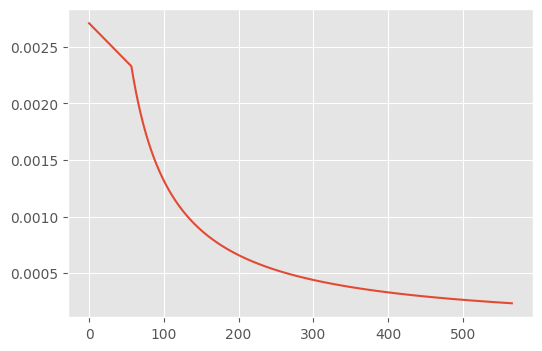

In [272]:
plot_func_fund(604486)

In [273]:
def plot_func_fund_li_nolin(fundID):
    a_hat = estimates.loc[estimates["fund_id"] == fundID, "a"].iat[0]
    b_hat = estimates.loc[estimates["fund_id"] == fundID, "b"].iat[0]
    k_hat = estimates.loc[estimates["fund_id"] == fundID, "K"].iat[0]

    q_grid = np.linspace(0.0001, 3*k_hat, 1000)

    h = h_param

    alpha_grid = alpha_smooth_gauss(a_hat, b_hat, k_hat, q_grid, h)

    plt.figure(figsize=(6,4))
    plt.plot(q_grid,alpha_grid)
    
    a_hatl = estimates_lin.loc[estimates_lin["fund_id"] == fundID, "a_lin"].iat[0]
    b_hatl = estimates_lin.loc[estimates_lin["fund_id"] == fundID, "b_lin"].iat[0]
    #k_hatl = estimates.loc[estimates["fund_id"] == fundID, "K"].iat[0]


    alpha_gridl = a_hatl - b_hatl * q_grid

    #plt.figure(figsize=(6,4))
    plt.plot(q_grid,alpha_gridl)

    
    plt.show()

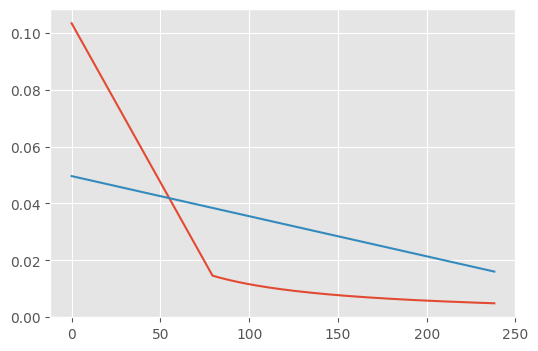

In [339]:
plot_func_fund_li_nolin(106978)

In [275]:
def plot_fit_fund_li_nolin(fundID):

    g = df[df["fund_id"] == fundID].sort_values("time")
    q = g["TNA"].to_numpy(float)
    y = g["Y"].to_numpy(float)
    F = g[["F2", "F3", "F4", "F5"]].to_numpy(float)


    a_hat = estimates.loc[estimates["fund_id"] == fundID, "a"].iat[0]
    b_hat = estimates.loc[estimates["fund_id"] == fundID, "b"].iat[0]
    k_hat = estimates.loc[estimates["fund_id"] == fundID, "K"].iat[0]

    beta_col = [c for c in estimates.columns if c.startswith("beta")]
    beta_hat = estimates.loc[estimates["fund_id"] == fundID, beta_col].to_numpy(float).reshape(-1, 1)

    
    
    a_hatl = estimates_lin.loc[estimates_lin["fund_id"] == fundID, "a_lin"].iat[0]
    b_hatl = estimates_lin.loc[estimates_lin["fund_id"] == fundID, "b_lin"].iat[0]
    #k_hatl = estimates.loc[estimates["fund_id"] == fundID, "K"].iat[0]

    beta_coll = [c for c in estimates_lin.columns if c.startswith("beta")]
    beta_hatl = estimates_lin.loc[estimates_lin["fund_id"] == fundID, beta_coll].to_numpy(float).reshape(-1, 1)

    h = h_param

    y_hat_nl = alpha_smooth_gauss(a_hat, b_hat, k_hat, q, h) + F.dot(beta_hat).flatten()

    y_hat_lin = (a_hatl - b_hatl * q) + F.dot(beta_hatl).flatten()

    plt.figure(figsize=(6,4))
    plt.scatter(y_hat_nl, y, s=18, alpha= 0.8, marker="x", label= "Non-linear")
    plt.scatter(y_hat_lin, y, s=18, alpha= 0.3, label= "linear")

    plt.xlabel("Predicted Y")
    plt.ylabel("Actual Y")
    plt.title(f"Actual vs. Predicted Values for Fund {fundID}")
    plt.legend();
    
    plt.show()

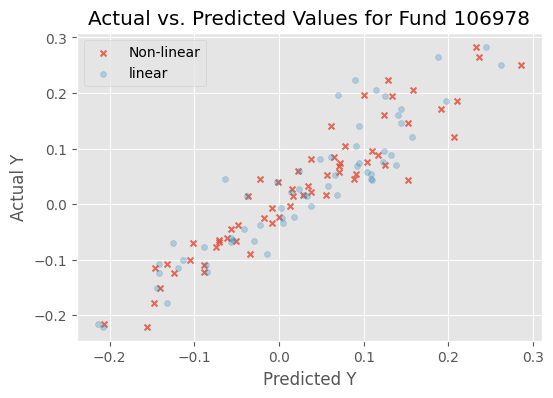

In [340]:
plot_fit_fund_li_nolin(106978)

In [277]:
def plot_fit_fund_li_nolin_subsBeta(fundID):

    g = df[df["fund_id"] == fundID].sort_values("TNA")
    q = g["TNA"].to_numpy(float)
    y = g["Y"].to_numpy(float)
    F = g[["F2", "F3", "F4", "F5"]].to_numpy(float)


    a_hat = estimates.loc[estimates["fund_id"] == fundID, "a"].iat[0]
    b_hat = estimates.loc[estimates["fund_id"] == fundID, "b"].iat[0]
    k_hat = estimates.loc[estimates["fund_id"] == fundID, "K"].iat[0]

    beta_col = [c for c in estimates.columns if c.startswith("beta")]
    beta_hat = estimates.loc[estimates["fund_id"] == fundID, beta_col].to_numpy(float).reshape(-1, 1)

    q_grid = np.linspace(0.0001, q.max(), 10000)

    y_subs = y - F.dot(beta_hat).flatten()
    
    a_hatl = estimates_lin.loc[estimates_lin["fund_id"] == fundID, "a_lin"].iat[0]
    b_hatl = estimates_lin.loc[estimates_lin["fund_id"] == fundID, "b_lin"].iat[0]
    #k_hatl = estimates.loc[estimates["fund_id"] == fundID, "K"].iat[0]

    beta_coll = [c for c in estimates_lin.columns if c.startswith("beta")]
    beta_hatl = estimates_lin.loc[estimates_lin["fund_id"] == fundID, beta_coll].to_numpy(float).reshape(-1, 1)

    y_subsl = y - F.dot(beta_hatl).flatten()

    h = h_param

    y_hat_nl_subs = alpha_smooth_gauss(a_hat, b_hat, k_hat, q, h) 

    y_hat_lin_subs = (a_hatl - b_hatl * q) 

    plt.figure(figsize=(6,4))
    #plt.scatter(q, y, s=18, alpha= 0.3, marker="x", label= "Y ")
    plt.scatter(q, y_subs, s=18, alpha= 0.3, label= "Y - (betas)")
    
    plt.plot(q,y_hat_nl_subs)
    plt.plot(q,y_hat_lin_subs)
    

    plt.xlabel("size q")
    plt.ylabel("Y - F dot betas")
    plt.title(f"Values for Fund {fundID}")
    plt.legend();
    
    plt.show()



    plt.figure(figsize=(6,4))
    plt.scatter(y_hat_nl_subs, y_subs, s=18, alpha= 0.8, marker="x", label= "Non-linear")
    plt.scatter(y_hat_lin_subs, y_subsl, s=18, alpha= 0.3, label= "linear")

    plt.xlabel("Predicted Y")
    plt.ylabel("Y - F dot beta")
    plt.title(f"Actual vs. Predicted Values for Fund {fundID}")
    plt.legend();

    
    plt.show()

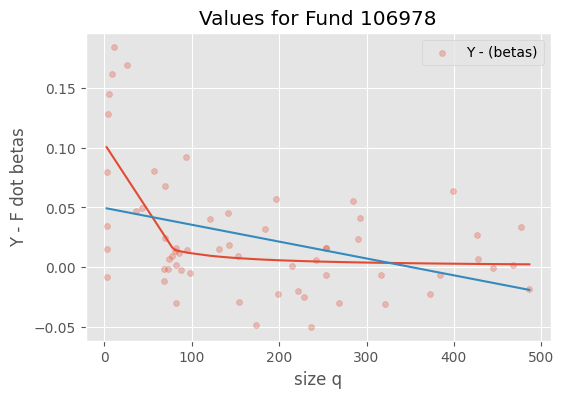

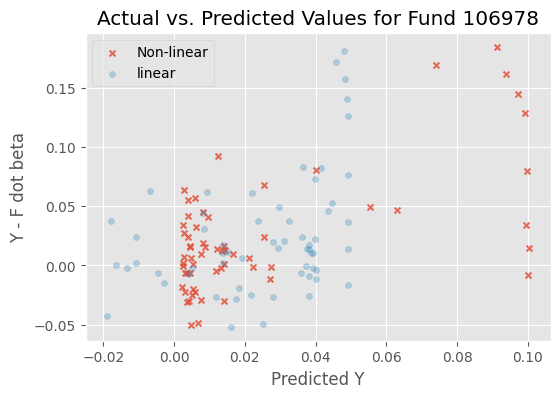

In [341]:
plot_fit_fund_li_nolin_subsBeta(106978)

Excel with results of both specifications

In [279]:
sheet = (estimates_lin[["fund_id", "a_lin", "b_lin"]]
         .merge(estimates[["fund_id", "a", "b", "K"]], on="fund_id")
         .rename(columns={"a":"a_nlin", "b":"b_nl"}))

In [280]:
sheet.to_excel("AllFundsBothSpecifications.xlsx", index=False)

Results for funds with positive a nd b in the linear fit

In [281]:
est_lin_pos = estimates_lin.query("a_lin >= 0 and b_lin > 0").copy()
#est_nl_pos = estimates.query("a >= 0 and b > 0").copy()

In [282]:
est_nl_pos = estimates[estimates.fund_id.isin(set(est_lin_pos.fund_id))]
est_nl_pos

,a,b,K,beta1,beta2,beta3,beta4,SSE,success,n_obs,R2,fund_id,K_theory
1,0.003305,2.644972e-08,956.523005,1.009870,0.619490,-0.018585,0.039602,0.054539,True,316,0.933170,100003,62477.836052
2,0.007402,6.621432e-06,785.092002,1.009720,0.148894,-0.277782,0.027508,0.036902,True,419,0.961838,100004,558.941162
3,0.006195,1.590428e-07,4310.975355,0.843026,0.144365,0.333556,0.035365,0.011372,True,184,0.953984,100006,19474.342992
4,0.018989,3.105228e-04,46.133356,1.090123,0.738502,-0.504273,0.148665,0.110349,True,277,0.912027,100009,30.575312
5,-1.206831,-1.746756e-02,69.949912,0.879262,0.085707,0.211383,0.038335,0.049149,True,341,0.913273,100010,34.544916
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2312,0.060213,3.033678e-03,20.276467,0.963373,0.848109,0.303166,-0.132928,0.004081,True,63,0.971009,603034,9.924108
2313,0.007503,1.281772e-04,64.532374,0.966205,0.038574,0.183228,0.025996,0.001907,True,63,0.971991,603041,29.266374
2314,0.006428,-2.159890e-05,46.185811,0.924702,0.281982,-0.272348,-0.051015,0.003590,True,63,0.957530,603044,-148.812698
2316,0.008326,1.079223e-04,56.859533,0.811253,1.071629,-0.042786,0.016686,0.003821,True,62,0.966968,603104,38.574335


In [283]:
df_positive = df[df.fund_id.isin(set(est_lin_pos.fund_id))]

In [284]:
df_single_fund = df_positive
df_single_fund["fund_id"] = 1
df_single_fund

/var/folders/f_/lhvlm_j976x1lyjxn3zx6c3m0000gn/T/ipykernel_1981/976209813.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_single_fund["fund_id"] = 1


,time,fund_index,fund_id,Y,TNA,style_1,style_2,style_3,style_4,style_5,...,style_14,style_15,style_16,style_17,style_18,F1,F2,F3,F4,F5
517584,223,1,1,0.046934,8.809140,0,0,0,0,0,...,0,0,0,0,0,1.0,0.035443,0.005237,-0.005185,0.0258
519905,224,1,1,0.048822,23.466464,0,0,0,0,0,...,0,0,0,0,0,1.0,-0.010269,0.035889,0.007661,0.0341
522226,225,1,1,-0.010571,40.921777,0,0,0,0,0,...,0,0,0,0,0,1.0,0.018486,0.005064,-0.026427,-0.0267
524547,226,1,1,-0.030343,59.166951,0,0,0,0,0,...,0,0,0,0,0,1.0,-0.012031,-0.023049,-0.011480,-0.0471
526868,227,1,1,0.049696,73.954055,0,0,0,0,0,...,0,0,0,0,0,1.0,0.009790,0.022080,0.000757,0.0229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1241733,534,2319,1,0.002004,48.114893,0,0,0,0,0,...,0,0,0,0,0,1.0,0.012473,-0.008616,-0.013872,0.0272
1244054,535,2319,1,-0.002624,48.052107,0,0,0,0,0,...,0,0,0,0,0,1.0,-0.017441,-0.033533,-0.021151,0.0766
1246375,536,2319,1,0.030620,47.881574,0,0,0,0,0,...,0,0,0,0,0,1.0,0.016911,0.002096,0.037129,-0.0685
1248696,537,2319,1,0.016188,45.260159,0,0,0,0,0,...,0,0,0,0,0,1.0,0.020159,0.004677,-0.013553,0.0029


In [285]:
estimates_single_fund = estimate_all_funds(df_single_fund)
estimates_single_fund

100%|██████████| 1/1 [00:02<00:00,  2.75s/it]


,a,b,K,beta1,beta2,beta3,beta4,SSE,success,n_obs,R2,fund_id
0,0.004917,0.000003,782.607997,0.951478,0.373523,-0.040822,0.013204,138.021532,True,436378,0.875037,1


benchmark discounted R2

In [286]:
def estimate_one_fund_lin(fund_df):
    """Returns dict with a, b, beta1...betak, R2, SSE, n_obs for a single fund"""

    y = fund_df["Y"].to_numpy(float)

    X = fund_df[["TNA", "F2", "F3", "F4", "F5"]].copy()
    X.insert(0, "const", 1.0)
    X["TNA"] = -X["TNA"]

    mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
    X, y = X[mask].to_numpy(), y[mask]

    res = sm.OLS(y, X).fit()

    a_hat = res.params[0]
    b_hat = res.params[1]
    betas = res.params[2:]

    K_theory = a_hat / (2 * b_hat)

    out = {
        "a_lin":a_hat,
        "b_lin":b_hat,
        **{f"beta{j+1}": betas[j] for j in range(len(betas))},
        "R2": res.rsquared,
        "SSE": res.ssr,
        "n_obs": len(y),
        "K_the_lin": K_theory
    }

    return out



def estimate_all_funds_linear(df):
    """
    OLS of every fund in the dataset df
    """

    results = []

    for fid, g in tqdm(df.groupby("fund_id")):
        est = estimate_one_fund_lin(g)
        if est is not None:
            est["fund_id"]=fid
            results.append(est)

    return pd.DataFrame(results)








In [287]:
def alpha_lin_gauss(a, b, K, q, h):
    
    return (a - b*q)

In [289]:
def add_gross_alpha_R2(estimates_df, method):
    
    r2_values = []

    for fid in estimates_df["fund_id"]:

        g = df[df["fund_id"] == fid].sort_values("TNA")
        q = g["TNA"].to_numpy(float)
        y = g["Y"].to_numpy(float)
        F = g[["F2", "F3", "F4", "F5"]].to_numpy(float)
    
        a = estimates_df.loc[estimates_df["fund_id"] == fid].iloc[0, 0]
        b = estimates_df.loc[estimates_df["fund_id"] == fid].iloc[0, 1]
        k = estimates_df.loc[estimates_df["fund_id"] == fid].iloc[0, 2]

        beta_col = [c for c in estimates_df.columns if c.startswith("beta")]
        beta = estimates_df.loc[estimates_df["fund_id"] == fid, beta_col].to_numpy(float).reshape(-1, 1)

        y_subs = y - F.dot(beta).flatten()

        h = h_param

        y_hat_subs = method(a, b, k, q, h) 


        # R2 = 1 - (sum of squares of residuals) / (total sum of squares)
        ss_total = np.sum((y_subs - np.mean(y_subs)) ** 2)
        ss_residual = np.sum((y_subs - y_hat_subs) ** 2)

        r_squared = 1 - (ss_residual / ss_total)

        r2_values.append({"fund_id": fid, "r_squared": r_squared})

    r2_df = pd.DataFrame(r2_values)
    
    estimates_df = pd.merge(estimates_df, r2_df, on="fund_id", how="left")

    return estimates_df
    

In [290]:
est_lin_pos_gross_r2 = add_gross_alpha_R2(est_lin_pos, alpha_lin_gauss)

In [291]:
est_lin_pos_gross_r2

,a_lin,b_lin,beta1,beta2,beta3,beta4,R2,SSE,n_obs,K_the_lin,fund_id,r_squared
0,0.004300,1.583310e-06,1.009327,0.619777,-0.017121,0.039970,0.866277,0.109129,316,1357.875384,100003,0.000577
1,0.004346,1.460467e-06,1.009456,0.147759,-0.277096,0.028058,0.922869,0.074584,419,1487.950849,100004,0.003646
2,0.006741,5.913177e-07,0.843809,0.142745,0.331572,0.036263,0.907920,0.022755,184,5700.289753,100006,0.018171
3,0.007891,1.787235e-05,1.085414,0.732124,-0.504707,0.145129,0.820675,0.224937,277,220.759662,100009,0.004509
4,0.005639,2.637993e-06,0.836585,0.057675,0.165395,0.050502,0.790500,0.118724,341,1068.760811,100010,0.004026
...,...,...,...,...,...,...,...,...,...,...,...,...
1769,0.010257,4.415307e-04,0.972123,0.838933,0.289786,-0.149562,0.938669,0.008634,63,11.615427,603034,0.013772
1770,0.001456,4.801583e-06,0.965359,0.038410,0.193675,0.028285,0.941999,0.003950,63,151.604108,603041,0.001731
1771,0.001418,7.012831e-07,0.927379,0.285378,-0.279294,-0.046574,0.911322,0.007496,63,1011.269566,603044,0.000077
1772,0.007462,8.449768e-05,0.810392,1.071016,-0.041594,0.017310,0.933816,0.007655,62,44.154539,603104,0.016082


In [292]:
est_nl_pos_gross_r2 = add_gross_alpha_R2(est_nl_pos, alpha_smooth_gauss)

In [293]:
est_nl_pos_gross_r2

,a,b,K,beta1,beta2,beta3,beta4,SSE,success,n_obs,R2,fund_id,K_theory,r_squared
0,0.003305,2.644972e-08,956.523005,1.009870,0.619490,-0.018585,0.039602,0.054539,True,316,0.933170,100003,62477.836052,0.001039
1,0.007402,6.621432e-06,785.092002,1.009720,0.148894,-0.277782,0.027508,0.036902,True,419,0.961838,100004,558.941162,0.014061
2,0.006195,1.590428e-07,4310.975355,0.843026,0.144365,0.333556,0.035365,0.011372,True,184,0.953984,100006,19474.342992,0.018410
3,0.018989,3.105228e-04,46.133356,1.090123,0.738502,-0.504273,0.148665,0.110349,True,277,0.912027,100009,30.575312,0.023388
4,-1.206831,-1.746756e-02,69.949912,0.879262,0.085707,0.211383,0.038335,0.049149,True,341,0.913273,100010,34.544916,0.187173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769,0.060213,3.033678e-03,20.276467,0.963373,0.848109,0.303166,-0.132928,0.004081,True,63,0.971009,603034,9.924108,0.072105
1770,0.007503,1.281772e-04,64.532374,0.966205,0.038574,0.183228,0.025996,0.001907,True,63,0.971991,603041,29.266374,0.036292
1771,0.006428,-2.159890e-05,46.185811,0.924702,0.281982,-0.272348,-0.051015,0.003590,True,63,0.957530,603044,-148.812698,0.042705
1772,0.008326,1.079223e-04,56.859533,0.811253,1.071629,-0.042786,0.016686,0.003821,True,62,0.966968,603104,38.574335,0.017866


In [294]:
cmp = (est_lin_pos_gross_r2[["fund_id", "r_squared", "K_the_lin"]].rename(columns={"r_squared":"R2_gross_lin"})).merge(est_nl_pos_gross_r2[["fund_id", "r_squared","K"]].rename(columns={"r_squared":"R2_gross_nl"}), on="fund_id", how="inner")
cmp["R2_gross_delta"] = cmp["R2_gross_nl"] - cmp["R2_gross_lin"]
print("delta = nl - lin, only for a,b>0 in the lin spec")
cmp[["R2_gross_lin", "R2_gross_nl", "R2_gross_delta"]].mean()

delta = nl - lin, only for a,b>0 in the lin spec


R2_gross_lin      0.022421
R2_gross_nl       0.037498
R2_gross_delta    0.015077
dtype: float64

In [351]:
cmp1 = (est_lin_pos_gross_r2[["fund_id", "r_squared", "K_the_lin"]].rename(columns={"r_squared":"R2_gross_lin"})).merge(est_nl_pos_gross_r2[["fund_id", "r_squared","K","K_theory"]].rename(columns={"r_squared":"R2_gross_nl"}), on="fund_id", how="inner")
cmp1["K_delta"] = cmp1["K"] - cmp1["K_theory"]
print("delta = nl - lin, only for a,b>0 in the lin spec")
cmp1[["K_delta", "K", "K_theory"]].mean()
len(cmp1)

delta = nl - lin, only for a,b>0 in the lin spec


1774

Positive a and b in the non linear specification

In [ ]:
est_nl_pos_gross_r2_nonLinearPositive = est_nl_pos_gross_r2.query("a >= 0 and b > 0").copy()
est_nl_pos_gross_r2_nonLinearPositive.shape

(1277, 14)

In [297]:
cmp = (est_lin_pos_gross_r2[["fund_id", "r_squared", "K_the_lin"]].rename(columns={"r_squared":"R2_gross_lin"})).merge(est_nl_pos_gross_r2_nonLinearPositive[["fund_id", "r_squared","K","K_theory"]].rename(columns={"r_squared":"R2_gross_nl"}), on="fund_id", how="inner")
cmp["R2_gross_delta"] = cmp["R2_gross_nl"] - cmp["R2_gross_lin"]
print("delta = nl - lin, only for a,b>0 in the lin spec")
cmp[["R2_gross_lin", "R2_gross_nl", "R2_gross_delta"]].mean()

delta = nl - lin, only for a,b>0 in the lin spec


R2_gross_lin      0.026209
R2_gross_nl       0.042439
R2_gross_delta    0.016230
dtype: float64

In [298]:
cmp["K_delta"] = cmp["K"] - cmp["K_theory"]
print("delta = nl - theoretical, only for a,b>0 in both specifications")
print(cmp[["K_delta", "K", "K_theory"]].mean())
print(cmp[["K_delta", "K", "K_theory"]].std())

delta = nl - theoretical, only for a,b>0 in both specifications
K_delta     -496.803118
K            857.616711
K_theory    1354.419830
dtype: float64
K_delta     8325.200061
K           2627.456983
K_theory    9453.018737
dtype: float64


In [333]:
cmp['K_theory'].idxmax()

185

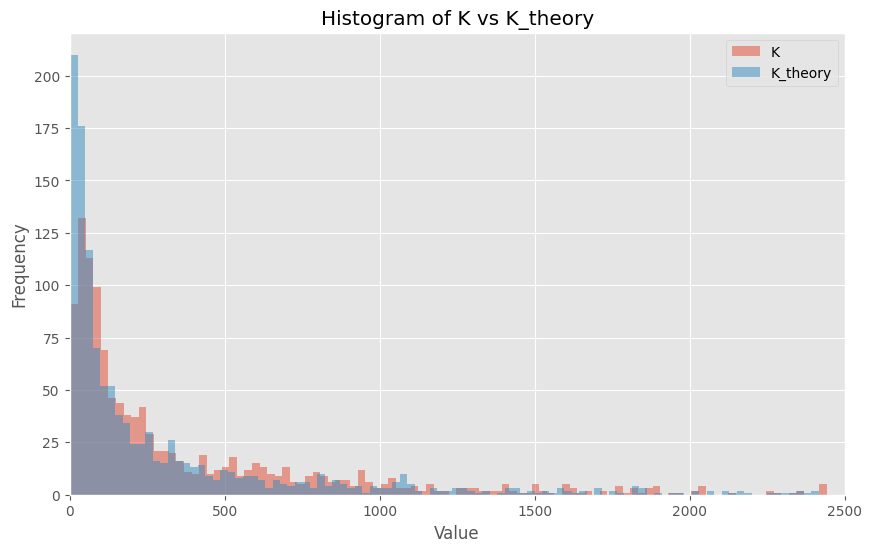

In [299]:
plt.figure(figsize=(10, 6))

filter1 = cmp[cmp['K'] < 2500]
filter2 = cmp[cmp['K_theory'] < 2500]

plt.hist(filter1['K'], bins=100, alpha=0.5, label='K')
plt.hist(filter2['K_theory'], bins=100, alpha=0.5, label='K_theory')

plt.title('Histogram of K vs K_theory')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xlim(0, 2500)
plt.legend()
plt.savefig('k_vs_k_theory_histograms.png')

In [376]:
cmp.loc[cmp['K_theory'].idxmax()]

fund_id           101455.000000
R2_gross_lin           0.040656
K_the_lin          70421.041224
R2_gross_nl            0.042979
K                  28207.374423
K_theory          255787.950903
R2_gross_delta         0.002323
Name: 185, dtype: float64

In [301]:
est_nl_pos_gross_r2_nonLinearPositive

,a,b,K,beta1,beta2,beta3,beta4,SSE,success,n_obs,R2,fund_id,K_theory,r_squared
0,0.003305,2.644972e-08,956.523005,1.009870,0.619490,-0.018585,0.039602,0.054539,True,316,0.933170,100003,62477.836052,0.001039
1,0.007402,6.621432e-06,785.092002,1.009720,0.148894,-0.277782,0.027508,0.036902,True,419,0.961838,100004,558.941162,0.014061
2,0.006195,1.590428e-07,4310.975355,0.843026,0.144365,0.333556,0.035365,0.011372,True,184,0.953984,100006,19474.342992,0.018410
3,0.018989,3.105228e-04,46.133356,1.090123,0.738502,-0.504273,0.148665,0.110349,True,277,0.912027,100009,30.575312,0.023388
5,0.008394,1.148455e-04,36.563410,0.960514,-0.048381,-0.338006,0.106680,0.009384,True,242,0.980909,100016,36.546017,0.026001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1768,0.006138,7.405039e-06,718.749855,0.852504,0.124212,0.239512,-0.081948,0.005515,True,65,0.922636,602953,414.449241,0.017702
1769,0.060213,3.033678e-03,20.276467,0.963373,0.848109,0.303166,-0.132928,0.004081,True,63,0.971009,603034,9.924108,0.072105
1770,0.007503,1.281772e-04,64.532374,0.966205,0.038574,0.183228,0.025996,0.001907,True,63,0.971991,603041,29.266374,0.036292
1772,0.008326,1.079223e-04,56.859533,0.811253,1.071629,-0.042786,0.016686,0.003821,True,62,0.966968,603104,38.574335,0.017866


2.9215200511830514e-252
81.00227142701462
1.098204809262773


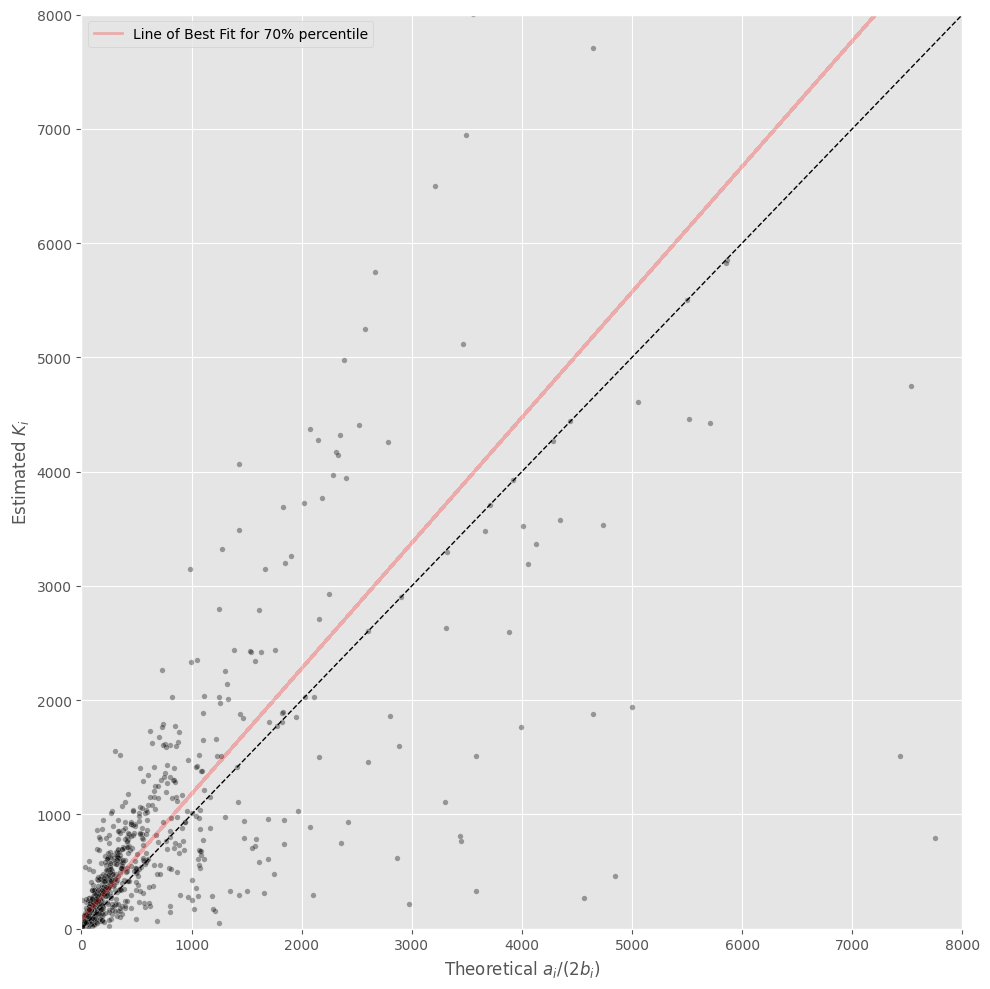

In [385]:
plt.figure(figsize=(10,10))



sns.scatterplot(data=est_nl_pos_gross_r2_nonLinearPositive, x="K_theory", y="K",s=16, alpha=0.35, color='black')

# 45° reference line (on union of plotted data)
lims = plt.gca().get_xlim()

plt.plot(lims, lims, 'k--', lw=1)
plt.xlim(0, 8000); plt.ylim(0, 8000)

# Calculate the 99th percentile of the 'K_theory' column
k_theory_90th_percentile = np.percentile(cmp['K_theory'], 95)

# Filter the DataFrame to include only rows where 'K_theory' is within the limit
filtered_k_theory = cmp[cmp['K_theory'] <= k_theory_90th_percentile]['K_theory']
filtered_k = cmp[cmp['K_theory'] <= k_theory_90th_percentile]['K']

# --- Perform Linear Regression with Statsmodels to get p-value ---
# Add a constant (intercept) to the independent variable
X = sm.add_constant(filtered_k_theory)
y = filtered_k

# Create and fit the OLS (Ordinary Least Squares) model
model = sm.OLS(y, X)
results = model.fit()

# Extract the slope and p-value for the K_theory variable
slope = results.params['K_theory']
p_value = results.pvalues['K_theory']
intercept = results.params['const']
print(p_value)
print(intercept)
print(slope)

# Perform polyfit on the filtered data
#slope, intercept = np.polyfit(filtered_k_theory, filtered_k, 1)
# Plot the best-fit line
plt.plot(est_nl_pos_gross_r2_nonLinearPositive['K_theory'], slope * est_nl_pos_gross_r2_nonLinearPositive['K_theory'] + intercept, color='red', linestyle='-', alpha=0.25, lw=2, label='Line of Best Fit for 70% percentile')

# Add the legend to display the new line's label
plt.legend()


plt.xlabel(r"Theoretical $a_i/(2b_i)$")
plt.ylabel(r"Estimated $K_i$")
#plt.title(r"$K$ vs Theoretical $a/(2b)$")
plt.tight_layout()
plt.show()

Analysis per percentiles

In [303]:
# Count the number of funds where 'K_theory' is greater than the 99th percentile
dropped_funds_direct = len(cmp[cmp['K_theory'] > k_theory_95th_percentile])
print(f"Funds dropped (direct method): {dropped_funds_direct}")

Funds dropped (direct method): 64


In [323]:
# Assuming 'cmp' DataFrame is already loaded and available.
# This code will produce a table summarizing the mean values for different percentiles.

# Define the percentiles to analyze
percentiles = [50, 80, 90, 95, 99]

# Create an empty list to store the results for each percentile
results = []

# Loop through each percentile
for p in percentiles:
    # Calculate the percentile value of 'K_theory'
    k_theory_percentile = np.percentile(cmp['K_theory'], p)
    
    # Filter the DataFrame based on the current percentile
    filtered_cmp = cmp[cmp['K_theory'] <= k_theory_percentile]
    
    # Calculate the 'K_delta' for the filtered data
    filtered_cmp["K_delta"] = filtered_cmp["K"] - filtered_cmp["K_theory"]
    
    # Calculate the mean of the relevant columns
    mean_values = filtered_cmp[["K_delta", "K", "K_theory"]].mean()
    
    # Create a dictionary to hold the results for this percentile
    result_dict = {
        'Percentile': f"{p}%",
        'K Mean': mean_values['K'],
        'K_theory Mean': mean_values['K_theory'],
        'Difference': mean_values['K_delta']
    }
    
    # Add the dictionary to our results list
    results.append(result_dict)

# Convert the list of dictionaries into a DataFrame for a clean table output
results_df = pd.DataFrame(results)

# Print the final table
print(results_df)

  Percentile      K Mean  K_theory Mean  Difference
0        50%   94.323842      48.469921   45.853920
1        80%  241.541062     146.508175   95.032887
2        90%  348.673209     243.340926  105.332282
3        95%  471.233465     355.335535  115.897930
4        99%  694.407884     659.333142   35.074741


/var/folders/f_/lhvlm_j976x1lyjxn3zx6c3m0000gn/T/ipykernel_1981/2783664472.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cmp["K_delta"] = filtered_cmp["K"] - filtered_cmp["K_theory"]
/var/folders/f_/lhvlm_j976x1lyjxn3zx6c3m0000gn/T/ipykernel_1981/2783664472.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cmp["K_delta"] = filtered_cmp["K"] - filtered_cmp["K_theory"]
/var/folders/f_/lhvlm_j976x1lyjxn3zx6c3m0000gn/T/ipykernel_1981/2783664472.py:19: SettingWithCopyWarning: 
A value

In [332]:

# Define the percentiles to analyze
percentiles = [50, 80, 90, 95, 99]

# Create an empty list to store the results for each percentile
results = []

# Loop through each percentile
for p in percentiles:
    # Calculate the percentile value of 'K_theory'
    k_theory_percentile = np.percentile(cmp['K_theory'], p)
    
    # Filter the DataFrame based on the current percentile
    filtered_cmp = cmp[cmp['K_theory'] <= k_theory_percentile]
    
    # Calculate the 'K_delta' for the filtered data
    filtered_cmp["K_delta"] = filtered_cmp["K"] - filtered_cmp["K_theory"]
    
    # Calculate the mean of the relevant columns
    mean_values = filtered_cmp[["K_delta", "K", "K_theory"]].mean()
    
    # Create a dictionary to hold the results for this percentile
    result_dict = {
        'Percentile': f"{p}%",
        'K Mean': mean_values['K'],
        'K_theory Mean': mean_values['K_theory'],
        'K_difference': mean_values['K_delta'],
        'Funds Included': len(filtered_cmp) # New column to count the funds
    }
    
    # Add the dictionary to our results list
    results.append(result_dict)

# Convert the list of dictionaries into a DataFrame for a clean table output
results_df = pd.DataFrame(results)

# Print the final table
print(results_df)

  Percentile      K Mean  K_theory Mean  K_difference  Funds Included
0        50%   94.323842      48.469921     45.853920             639
1        80%  241.541062     146.508175     95.032887            1021
2        90%  348.673209     243.340926    105.332282            1149
3        95%  471.233465     355.335535    115.897930            1213
4        99%  694.407884     659.333142     35.074741            1264


/var/folders/f_/lhvlm_j976x1lyjxn3zx6c3m0000gn/T/ipykernel_1981/199213775.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cmp["K_delta"] = filtered_cmp["K"] - filtered_cmp["K_theory"]
/var/folders/f_/lhvlm_j976x1lyjxn3zx6c3m0000gn/T/ipykernel_1981/199213775.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cmp["K_delta"] = filtered_cmp["K"] - filtered_cmp["K_theory"]
/var/folders/f_/lhvlm_j976x1lyjxn3zx6c3m0000gn/T/ipykernel_1981/199213775.py:16: SettingWithCopyWarning: 
A value is

In [355]:

# Define the percentiles to analyze
percentiles = [50, 80, 90, 95, 99, 100]

# Create an empty list to store the results for each percentile
results = []

# Loop through each percentile
for p in percentiles:
    # Calculate the percentile value of 'K_theory'
    k_theory_percentile = np.percentile(cmp['K_theory'], p)
    
    # Filter the DataFrame based on the current percentile
    filtered_cmp = cmp[cmp['K_theory'] <= k_theory_percentile]
    
    # Calculate the 'K_delta' for the filtered data
    filtered_cmp["K_delta"] = filtered_cmp["K"] - filtered_cmp["K_theory"]
    
    # Calculate the mean of the relevant columns
    mean_values = filtered_cmp[["K_delta", "K", "K_theory", "R2_gross_nl", "R2_gross_lin"]].mean()
    std_values = filtered_cmp[["K_delta", "K", "K_theory", "R2_gross_nl", "R2_gross_lin"]].std()


    # Create a dictionary to hold the results for this percentile
    result_dict = {
        'Percentile': f"{p}%",
        'K avg': mean_values['K'],
        'K theory avg': mean_values['K_theory'],
        'K difference': mean_values['K_delta'],
        'K standard deviation': std_values['K'],
        'K theory deviation': std_values['K_theory'],
        'Kdelta standard deviation': std_values['K_delta'],
        'Non-linear R2': mean_values['R2_gross_nl'],
        'Linear R2': mean_values['R2_gross_lin'],

        'Funds Included': len(filtered_cmp), # New column to count the funds
        'Funds K>K theory': len(filtered_cmp[filtered_cmp['K'] > filtered_cmp['K_theory']])
    }
    
    # Add the dictionary to our results list
    results.append(result_dict)

# Convert the list of dictionaries into a DataFrame for a clean table output
results_df = pd.DataFrame(results)

# Print the final table
print(results_df)

  Percentile       K avg  K theory avg  K difference  K standard deviation  \
0        50%   94.323842     48.469921     45.853920             77.885007   
1        80%  241.541062    146.508175     95.032887            271.058337   
2        90%  348.673209    243.340926    105.332282            466.609897   
3        95%  471.233465    355.335535    115.897930            820.754282   
4        99%  694.407884    659.333142     35.074741           1615.685378   
5       100%  857.616711   1354.419830   -496.803118           2627.456983   

   K theory deviation  Kdelta standard deviation  Non-linear R2  Linear R2  \
0           32.566258                  58.993865       0.049066   0.027907   
1          156.719508                 168.862078       0.044822   0.026847   
2          321.667957                 289.022644       0.043685   0.026651   
3          585.392654                 513.465178       0.043153   0.026327   
4         1857.265786                1132.413060       0.042666

/var/folders/f_/lhvlm_j976x1lyjxn3zx6c3m0000gn/T/ipykernel_1981/2034158601.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cmp["K_delta"] = filtered_cmp["K"] - filtered_cmp["K_theory"]
/var/folders/f_/lhvlm_j976x1lyjxn3zx6c3m0000gn/T/ipykernel_1981/2034158601.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cmp["K_delta"] = filtered_cmp["K"] - filtered_cmp["K_theory"]
/var/folders/f_/lhvlm_j976x1lyjxn3zx6c3m0000gn/T/ipykernel_1981/2034158601.py:16: SettingWithCopyWarning: 
A value

In [354]:
len(cmp[cmp['K'] > cmp['K_theory']])

1009

Decile and style analysis

In [ ]:
# Assuming your DataFrame is named 'df'
style_cols = [f'style_{i}' for i in range(1, 19)]

# Calculate the sum of the style columns for each fund
# We will use .loc to avoid a SettingWithCopyWarning if 'df' is a slice
df.loc[:, 'style_sum'] = df.loc[:, style_cols].sum(axis=1)

# Get the fund IDs for the funds with a style sum of 0
funds_with_no_style = df[df['style_sum'] == 0]['fund_id'].unique()

In [ ]:
# Count the number of unique funds with no style
num_funds_with_no_style = len(funds_with_no_style)

print(f"Number of funds that lack a style: {num_funds_with_no_style} 🔎")
print("Fund IDs of funds with no style:")
print(funds_with_no_style)

Number of funds that lack a style: 802 🔎
Fund IDs of funds with no style:
[100004 100006 100010 100017 100022 100030 100046 100047 100068 100076
 100097 100098 100099 100111 100127 100150 100160 100222 100228 100250
 100259 100275 100280 100287 100290 100298 100299 100305 100313 100324
 100333 100344 100350 100351 100358 100365 100395 100398 100399 100401
 100408 100424 100430 100451 100514 100521 100531 100535 100548 100561
 100564 100574 100610 100611 100622 100624 100644 100682 100688 100695
 100697 100698 100700 100705 100714 100715 100727 100740 100741 100756
 100767 100772 100773 100790 100809 100813 100829 100855 100875 100878
 100889 100891 100900 100910 100916 100921 100925 100962 100980 101020
 101023 101045 101055 101061 101068 101069 101079 101080 101081 101082
 101084 101085 101107 101132 101135 101158 101167 101181 101200 101211
 101216 101263 101268 101284 101285 101287 101300 101322 101354 101356
 101357 101358 101360 101364 101390 101397 101399 101400 101414 101457
 10

In [541]:
def estimate_one_fund_des(fund_df, h=0.01):
    """Return dict with a,b,K,beta1..betaK,SSE,n_obs for a single fund."""
    fund_df = fund_df.sort_values("time")
    q = fund_df["TNA"].to_numpy(float)            #lagged size
    y = fund_df["Y"].to_numpy(float)
    F = fund_df[["F2","F3","F4","F5"]].to_numpy(float)

    mask = (~np.isnan(q)) & (~np.isnan(y)) & (~np.isnan(F).any(axis=1)) & (q > 0)
    q, y, F = q[mask], y[mask], F[mask]
    if len(q) < 24:
        # print(q)             # skip tiny time-series
        return None

    # ----- initial guesses -----
    a0, b0, K0 = np.mean(y), 0.0, np.median(q)
    beta0      = np.linalg.lstsq(F, y, rcond=None)[0]
    x0         = np.concatenate(([a0, b0, K0], beta0))

    lb = np.concatenate(([-np.inf, -np.inf, 1e-6], [-np.inf]*len(beta0)))
    ub = np.concatenate(([ np.inf,  np.inf,  np.inf], [ np.inf]*len(beta0)))

    res = least_squares(residuals, x0, bounds=(lb, ub),
                        args=(q, y, F, h), method="trf", max_nfev=4000)

    ss_tot = np.sum((y - y.mean())**2)
    R2 = 1 - res.cost / ss_tot

    return {
        "a"      : res.x[0],
        "b"      : res.x[1],
        "K"      : res.x[2],
        **{f"beta{j+1}": res.x[3+j] for j in range(len(beta0))},
        "SSE"    : res.cost,
        "success": res.success,
        "n_obs"  : len(q),
        "R2"     : R2
    }

def estimate_all_funds_completeDes(df, h=0.01):
    """
    Run Gaussian-smooth NLLS for every fund in df.
    Returns a DataFrame of estimates and descriptive information for each fund
    """
    results = []
    
    # -------- Step 1: Run all estimations --------
    for fid, g in tqdm(df.groupby("fund_id")):
        est = estimate_one_fund_des(g, h)
        if est is not None:
            est["fund_id"] = fid

            # --- Get fund style ---
            style_cols = [f'style_{i}' for i in range(1, 19)]
            fund_styles = g[style_cols].iloc[0]
            
            if (fund_styles == 1).any():
                fund_style = fund_styles[fund_styles == 1].index[0].replace('style_', '')
                est["fund_style"] = fund_style
            else:
                est["fund_style"] = None

            # --- Add individual fund mean and median TNA ---
            est["TNA_mean"] = g['TNA'].mean()
            est["TNA_median"] = g['TNA'].median()
            
            results.append(est)

    estimates = pd.DataFrame(results)
    
    # ---
    estimates["K_theory"] = estimates["a"] / (2 * estimates["b"])
    estimates = add_gross_alpha_R2(estimates, alpha_smooth_gauss)

    # ---
    estimates = estimates[estimates.fund_id.isin(set(est_lin_pos.fund_id))]
    estimates2 = estimates.query("a >= 0 and b > 0").copy()

    
    # ---
    tna_series = estimates2.groupby("fund_id")["TNA_mean"].mean().dropna()
    tna_decile = pd.qcut(tna_series, 10, labels=False, duplicates='drop') + 1
    
    # Add the decile information back to the DataFrame
    estimates2 = estimates2.set_index("fund_id")
    estimates2['tna_decile'] = tna_decile
    estimates2 = estimates2.reset_index()

    return estimates2


In [542]:
est_nl_pos_gross_r2_nonLinearPositive_des = estimate_all_funds_completeDes(df, h =h_param)

100%|██████████| 2321/2321 [00:07<00:00, 294.74it/s]


In [543]:
est_nl_pos_gross_r2_nonLinearPositive_des

,fund_id,a,b,K,beta1,beta2,beta3,beta4,SSE,success,n_obs,R2,fund_style,TNA_mean,TNA_median,K_theory,r_squared,tna_decile
0,100003,0.003305,2.644972e-08,956.523005,1.009870,0.619490,-0.018585,0.039602,0.054539,True,316,0.933170,9,722.654595,689.533262,62477.836052,0.001039,8
1,100004,0.007402,6.621432e-06,785.092002,1.009720,0.148894,-0.277782,0.027508,0.036902,True,419,0.961838,None,996.372670,1064.860842,558.941162,0.014061,8
2,100006,0.006195,1.590428e-07,4310.975355,0.843026,0.144365,0.333556,0.035365,0.011372,True,184,0.953984,None,2391.626421,907.519798,19474.342992,0.018410,9
3,100009,0.018989,3.105228e-04,46.133356,1.090123,0.738502,-0.504273,0.148665,0.110349,True,277,0.912027,3,123.677453,73.046110,30.575312,0.023388,4
4,100016,0.008394,1.148455e-04,36.563410,0.960514,-0.048381,-0.338006,0.106680,0.009384,True,242,0.980909,18,114.530746,94.568754,36.546017,0.026001,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1272,602953,0.006138,7.405039e-06,718.749855,0.852504,0.124212,0.239512,-0.081948,0.005515,True,65,0.922636,7,747.107801,759.998667,414.449241,0.017702,8
1273,603034,0.060213,3.033678e-03,20.276467,0.963373,0.848109,0.303166,-0.132928,0.004081,True,63,0.971009,None,21.869613,21.257924,9.924108,0.072105,1
1274,603041,0.007503,1.281772e-04,64.532374,0.966205,0.038574,0.183228,0.025996,0.001907,True,63,0.971991,13,191.936921,214.661479,29.266374,0.036292,5
1275,603104,0.008326,1.079223e-04,56.859533,0.811253,1.071629,-0.042786,0.016686,0.003821,True,62,0.966968,None,49.190815,51.138400,38.574335,0.017866,2


In [544]:
est_nl_pos_gross_r2_nonLinearPositive_des[["K", "K_theory", "TNA_median", "r_squared"]].mean()

K              857.616711
K_theory      1354.419830
TNA_median     845.525024
r_squared        0.042439
dtype: float64

/var/folders/f_/lhvlm_j976x1lyjxn3zx6c3m0000gn/T/ipykernel_1981/1306544894.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


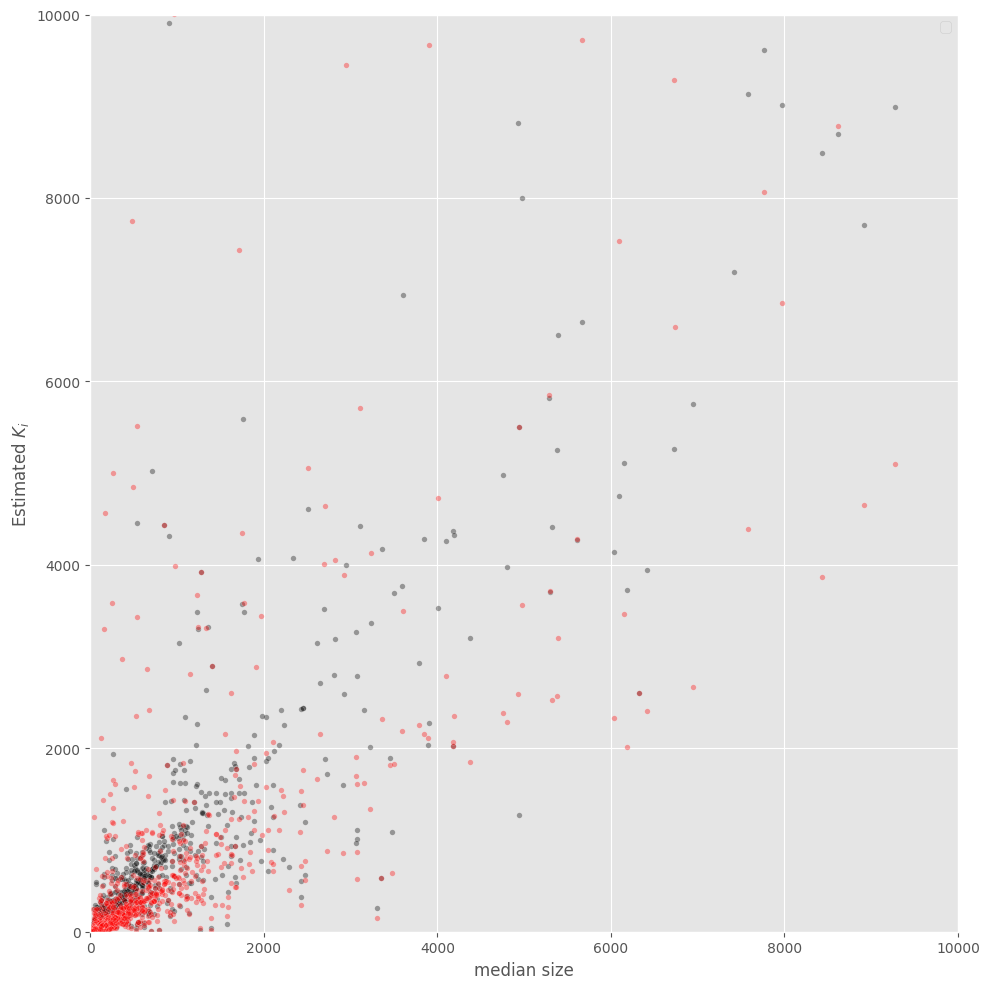

In [545]:
plt.figure(figsize=(10,10))



sns.scatterplot(data=est_nl_pos_gross_r2_nonLinearPositive_des, x="TNA_median", y="K",s=16, alpha=0.35, color='black')
sns.scatterplot(data=est_nl_pos_gross_r2_nonLinearPositive_des, x="TNA_median", y="K_theory",s=16, alpha=0.35, color='red')

# 45° reference line (on union of plotted data)
lims = plt.gca().get_xlim()

#plt.plot(lims, lims, 'k--', lw=1)

#plt.xlim(*lims)
#plt.ylim(*lims)

plt.xlim(0, 10000)
plt.ylim(0, 10000)


plt.legend()


plt.xlabel(r"median size")
plt.ylabel(r"Estimated $K_i$")
#plt.title(r"$K$ vs Theoretical $a/(2b)$")
plt.tight_layout()
plt.show()

Table for deciles of size

In [546]:
cmp_des = est_nl_pos_gross_r2_nonLinearPositive_des.copy()
cmp_des['K_difference'] = cmp_des['K'] - cmp_des['K_theory']


summary_table = cmp_des.groupby('tna_decile').agg(
    K_avg=('K', 'mean'),
    K_theory_avg=('K_theory', 'mean'),
    K_difference=('K_difference', 'mean'),
    mean_size = ('TNA_median', 'mean'),
    #K_standard_deviation=('K', 'std'),
    #K_theory_deviation=('K_theory', 'std'),
    #Kdelta_standard_deviation=('K_difference', 'std'),
    #Non_linear_R2=('R2', 'mean'),
    Funds_Included=('fund_id', 'count')
)

# 3. Calculate the count of funds where K > K_theory, by decile
funds_k_greater_than_k_theory = cmp_des[cmp_des['K'] > cmp_des['K_theory']].groupby('tna_decile')['fund_id'].count()
summary_table['Funds K>K theory'] = funds_k_greater_than_k_theory

# 4. Format the table for readability
# Set the 'tna_decile' column as the index
summary_table.index.name = 'Decile'

# Display the final table
print("Summary Table of Estimates by Fund Size Decile")
print(summary_table.to_string())



Summary Table of Estimates by Fund Size Decile
              K_avg  K_theory_avg  K_difference    mean_size  Funds_Included  Funds K>K theory
Decile                                                                                        
1         34.295573     19.778824     14.516749    32.730326             128               118
2         66.682814     45.304335     21.378479    57.051141             128               114
3         97.419223     67.428135     29.991088    87.990712             127               106
4        137.471521    114.962243     22.509278   127.110331             128               109
5        202.872246    186.296101     16.576145   207.218155             128               109
6        322.262967    298.751875     23.511091   296.962029             127                93
7        433.834226    507.468319    -73.634093   458.099219             128                93
8        700.343541   1129.835203   -429.491661   733.517063             127                95
9  

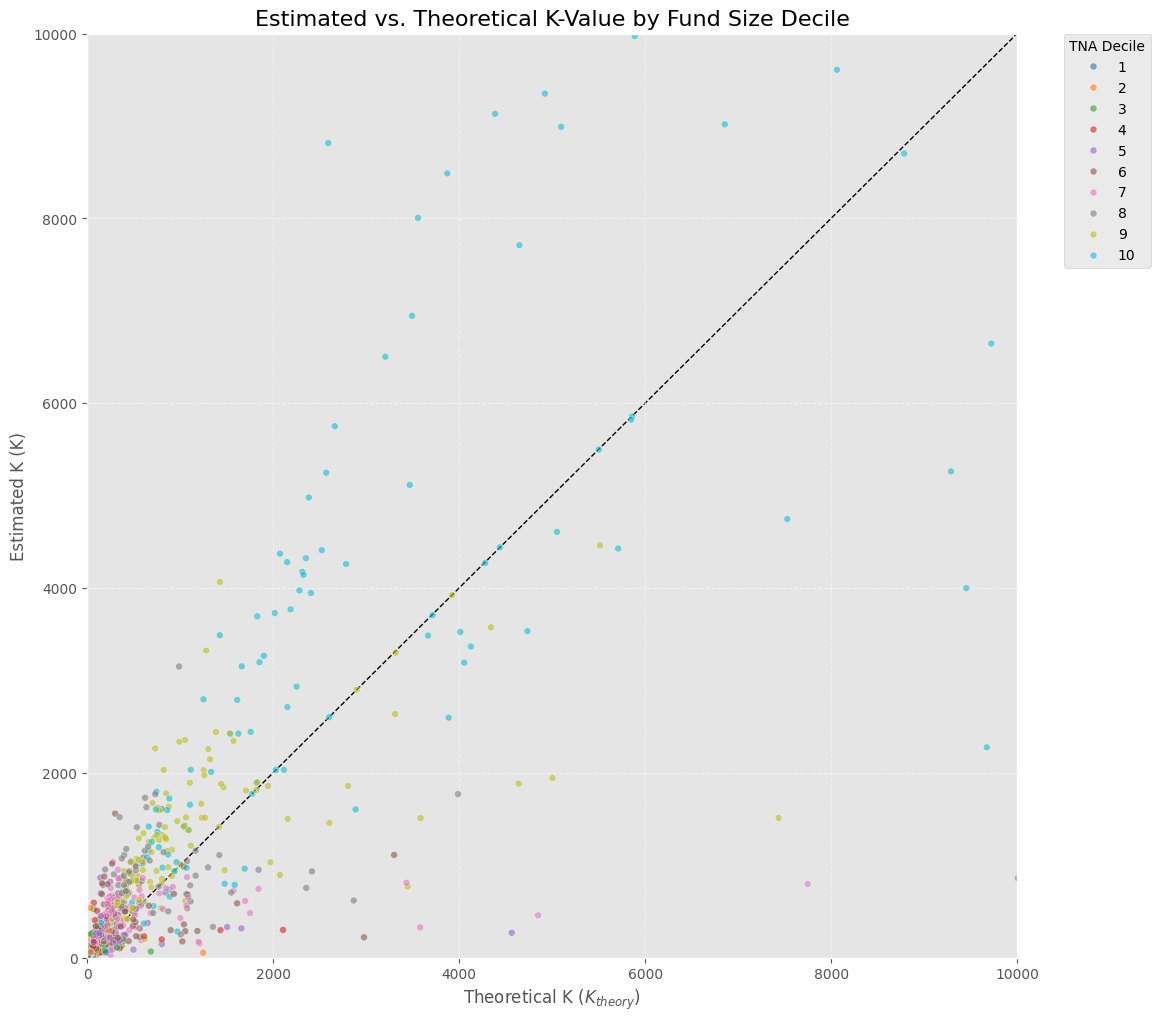

In [551]:
# Create the scatter plot
plt.figure(figsize=(12, 12))

# Use seaborn's scatterplot with 'hue' set to 'tna_decile' to color the points
# The palette 'viridis' is a good choice for continuous data, or a discrete palette
# like 'tab10' for the deciles. We'll use 'viridis' as it scales nicely.
sns.scatterplot(
    data=cmp_des,
    x="K_theory",
    y="K",
    hue="tna_decile",
    palette="tab10",
    s=25, # size of the points
    alpha=0.6 # transparency
)

# 45° reference line (on union of plotted data)
lims = plt.gca().get_xlim()
plt.plot(lims, lims, 'k--', lw=1, zorder=0) # zorder to place line behind points

# Set plot limits
plt.xlim(0, 10000)
plt.ylim(0, 10000)

# Add titles and labels
plt.title("Estimated vs. Theoretical K-Value by Fund Size Decile", fontsize=16)
plt.xlabel("Theoretical K ($K_{theory}$)", fontsize=12)
plt.ylabel("Estimated K (K)", fontsize=12)

# Add a legend and a color bar for the hue
plt.legend(title="TNA Decile", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [552]:

summary_table = cmp_des.groupby('fund_style').agg(
    K_avg=('K', 'mean'),
    K_theory_avg=('K_theory', 'mean'),
    K_difference=('K_difference', 'mean'),
    #K_standard_deviation=('K', 'std'),
    #K_theory_deviation=('K_theory', 'std'),
    #Kdelta_standard_deviation=('K_difference', 'std'),
    #Non_linear_R2=('R2', 'mean'),
    #Linear_R2=('R2_lin', 'mean'),
    Funds_Included=('fund_id', 'count')
)

# 3. Calculate the count of funds where K > K_theory, by style
funds_k_greater_than_k_theory = cmp_des[cmp_des['K'] > cmp_des['K_theory']].groupby('fund_style')['fund_id'].count()
summary_table['Funds K>K theory'] = funds_k_greater_than_k_theory

summary_table.index = pd.to_numeric(summary_table.index)
summary_table = summary_table.sort_index()
summary_table.index.name = 'Style'

# Display the final table
print("Summary Table of Estimates by Fund Style")
print(summary_table.to_string())


Summary Table of Estimates by Fund Style
             K_avg  K_theory_avg  K_difference  Funds_Included  Funds K>K theory
Style                                                                           
1       455.808016    322.629250    133.178766              22                16
2       293.085010    254.910765     38.174246              59                43
3       208.960359    287.986685    -79.026326              45                41
4       837.389072   1097.513849   -260.124777              32                18
5       234.632046    187.514873     47.117172              40                34
6       219.797394    133.942128     85.855267              44                39
7       674.523524    890.223163   -215.699639              31                23
8       685.961047    520.617998    165.343049              35                27
9       528.556157   1495.603150   -967.046993              57                48
10     1021.540361    973.628845     47.911516              32      